In [2]:
# installs
# !pip install wordcloud

In [3]:
import pandas as pd
import pyspark.sql.functions as F
from datetime import datetime
from pyspark.sql.types import *
from wordcloud import WordCloud, STOPWORDS
import numpy as np
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

In [4]:
# dataviz
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<hr />

# srag 2021
## update: 28-11-2021

<hr />

In [7]:
srag_2021 = spark.read.csv('gs://ai-covid19-datalake/raw/srag/2021/srag_2021_28nov.csv', inferSchema=True, header=True, sep=';')

In [8]:
# 2019 has 8589954878 as max value
# 2020 has 68719675014 as max value
# 2021 has 111669486174 as max value
def sum_ids(col, start):
    return col + start
udf_sum_ids = F.udf(sum_ids, LongType())

srag_2021 = srag_2021.withColumn('NU_NOTIFIC', F.monotonically_increasing_id())
srag_2021 = srag_2021.withColumn('NU_NOTIFIC',  udf_sum_ids(F.col('NU_NOTIFIC'), F.lit(206159025045)))

In [9]:
srag_2021.select('NU_NOTIFIC').describe().show()
print('How many distincts: ', srag_2021.select('NU_NOTIFIC').distinct().count())

+-------+--------------------+
|summary|          NU_NOTIFIC|
+-------+--------------------+
|  count|             1615809|
|   mean|2.360843340531424E11|
| stddev|1.962219025914123...|
|    min|        206159025045|
|    max|        266288762687|
+-------+--------------------+

How many distincts:  1615809


## about the columns

In [10]:
srag_2021.limit(5).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,...,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,OUT_ANIM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TOMO_OUT,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV,NU_NOTIFIC
0,03/01/2021,1,03/01/2021,1,SE,REGIONAL ARACAJU,2056,ARACAJU,280030,HOSPITAL GOVERNADOR JOAO ALVES FILHO,2816210,M,07/05/1972,48,3,3048,6,9,None,9.0,BRASIL,1,SE,REGIONAL ARACAJU,2056,BARRA DOS COQUEIROS,280060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,None,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,05/01/2021,0,None,None,None,None,None,1.0,None,None,None,NaN,NaN,NaN,NaN,None,None,None,None,None,4.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,206159025045
1,07/01/2021,1,05/01/2021,1,MG,MONTES CLAROS,1473,SALINAS,315700,HOSPITAL MUNICIPAL DR OSWALDO PREDILIANO SANTANA,2204649,F,29/04/1978,42,3,3042,5,4,None,2.0,BRASIL,1,MG,MONTES CLAROS,1473,SALINAS,315700,1.0,2.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,08/01/2021,0,None,None,None,None,None,NaN,None,None,None,NaN,NaN,NaN,NaN,None,None,None,None,None,5.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,None,07/01/2021,None,1.0,None,None,None,None,None,None,None,None,NaN,206159025046
2,07/01/2021,1,03/01/2021,1,PR,02RS METROPOLITANA,1356,CURITIBA,410690,HOSPITAL UNIVERSITARIO EVANGELICO MACKENZIE,15245,M,08/10/1970,50,3,3050,6,9,None,9.0,BRASIL,1,PR,02RS METROPOLITANA,1356,CURITIBA,410690,1.0,NaN,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,None,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,07/01/2021,0,None,None,None,None,None,1.0,None,None,None,2.0,1.0,2.0,2.0,None,None,None,None,None,4.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,206159025047
3,09/01/2021,1,05/01/2021,1,SP,GVE XXIX SAO JOSE DO RIO PRETO,1354,SAO JOSE DO RIO PRETO,354980,HOSPITAL SANTA HELENA SAO JOSE DO RIO PRETO,2797844,M,01/05/1979,41,3,3041,6,1,None,3.0,BRASIL,1,SP,GVE XXIX SAO JOSE DO RIO PRETO,1354,SAO JOSE DO RIO PRETO,354980,1.0,NaN,NaN,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,None,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,09/01/2021,0,None,None,None,None,None,1.0,521125,REPOSITOR DE MERCADORIAS,None,1.0,2.0,1.0,1.0,None,None,None,None,None,4.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,None,2,None,None,None,None,None,1.0,206159025048
4,11/01/2021,2,07/01/2021,1,SP,GVE IX FRANCO DA ROCHA,1334,MAIRIPORA,352850,HOSPITAL DE CLINICAS ANJO GABRIEL,115509,F,31/07/1945,75,3,3075,5,4,None,NaN,BRASIL,1,SP,GVE IX FRANCO DA ROCHA,1334,MAIRIPORA,352850,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,None,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11/01/2021,0,None,None,None,None,None,1.0,None,None,None,NaN,NaN,NaN,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,206159025049


In [11]:
# columns types according to srag dictionary
# date_type: 
date_type_columns = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_VGM', 'DT_RT_VGM', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 
                     'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_EVOLUCA', 'DT_DIGITA', 'DT_RES', 'DT_RES_AN', 'DT_TOMO', 'DT_CO_SOR']


# location categorical cols:
location_cat_cols = ['SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'SG_UF', 'ID_MN_RESI', 'CO_MUN_RES',
                     'CS_ZONA', 'ID_PAIS', 'CO_PAIS', 'HISTO_VGM', 'PAIS_VGM', 'CO_PS_VGM', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE',
                     'ID_MN_INTE', 'CO_MU_INTE']

# semi identifiers 
semi_id_cat_cols = ['NU_NOTIFIC', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'PAC_COCBO', 'PAC_DSCBO', 'AVE_SUINO', 'OUT_ANIM']


# symptoms
symptoms_cat_cols = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'DOR_ABD']


# risk factor 
risk_factor_cat_cols = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 
                        'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'FATOR_RISC']
                                   


# case descriptors
case_desc_cat_cols = ['SURTO_SG', 'NOSOCOMIAL', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'TP_SOR', 
                      'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO']

# test variables
tests_cat_cols = ['RES_IGG', 'RES_IGM', 'RES_IGA', 'RAIOX_RES', 'TOMO_RES', 'AMOSTRA', 'TP_AMOSTRA', 'OUT_SOR', 'SOR_OUT', 'TP_AM_SOR', 
                      'AN_ADENO', 'POS_AN_FLU', 'POS_AN_OUT', 'AN_PARA2', 'AN_PARA3', 'TP_FLU_AN', 'AN_VSR', 'AN_SARS2', 'AN_OUTRO', 'RES_AN', 'TP_FLU_PCR',
                      'PCR_SARS2', 'PCR_RESUL', 'POS_PCRFLU', 'PCR_FLUASU', 'PCR_FLUBLI', 'POS_PCROUT']



# varchar vars (could be id or numerical)
varchar_cols = ['NU_NOTIFIC', 'SEM_PRI', 'NU_IDADE_N', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC', 'OUT_ANTIV', 'RAIOX_OUT', 'OUT_AMOST',
               'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'TOMO_OUT', 'DS_AN_OUT']

In [12]:
srag_2021.printSchema()

root
 |-- DT_NOTIFIC: string (nullable = true)
 |-- SEM_NOT: integer (nullable = true)
 |-- DT_SIN_PRI: string (nullable = true)
 |-- SEM_PRI: integer (nullable = true)
 |-- SG_UF_NOT: string (nullable = true)
 |-- ID_REGIONA: string (nullable = true)
 |-- CO_REGIONA: integer (nullable = true)
 |-- ID_MUNICIP: string (nullable = true)
 |-- CO_MUN_NOT: integer (nullable = true)
 |-- ID_UNIDADE: string (nullable = true)
 |-- CO_UNI_NOT: integer (nullable = true)
 |-- CS_SEXO: string (nullable = true)
 |-- DT_NASC: string (nullable = true)
 |-- NU_IDADE_N: integer (nullable = true)
 |-- TP_IDADE: integer (nullable = true)
 |-- COD_IDADE: string (nullable = true)
 |-- CS_GESTANT: integer (nullable = true)
 |-- CS_RACA: integer (nullable = true)
 |-- CS_ETINIA: string (nullable = true)
 |-- CS_ESCOL_N: integer (nullable = true)
 |-- ID_PAIS: string (nullable = true)
 |-- CO_PAIS: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- ID_RG_RESI: string (nullable = true)
 |-- CO

## Formatting data type variables

In [13]:
# some values on var 'DT_NOTIFIC' has strange values, such as:  "UTI 17/02/2019 04/03/2019" or "DATA INTERNACAO 28/4/19.  20/08/2019- PERMANECE INTERNADA"
# Converting to proper data type on pyspark
before_count = srag_2021.count()
print('Number of lines before date formatting: ', before_count)
for col in date_type_columns:
    srag_2021 = srag_2021.withColumn(col, F.to_date(F.col(col), 'dd/MM/yyyy'))
#     if col == 'DT_NOTIFIC':
#         srag_2020 = srag_2020.filter((F.year(col) != 18) & (F.year(col) != 19) & (F.year(col) != 20) & (F.year(col) != 20))

after_count = srag_2021.count()
print('Number of lines after date formatting: ', srag_2021.count())
total_count = before_count - after_count
print('A total of lines deleted: ', total_count)

Number of lines before date formatting:  1615809
Number of lines after date formatting:  1615809
A total of lines deleted:  0


In [14]:
# Creating 'age' variable from the difference between date of birth and notification event
srag_2021 = srag_2021.withColumn("AGE_AT_NOTIF", F.datediff(F.col('DT_SIN_PRI'), F.col('DT_NASC'))/365.25)\
            .withColumn('AGE_AT_NOTIF', F.floor(F.col('AGE_AT_NOTIF')))

### some descriptions

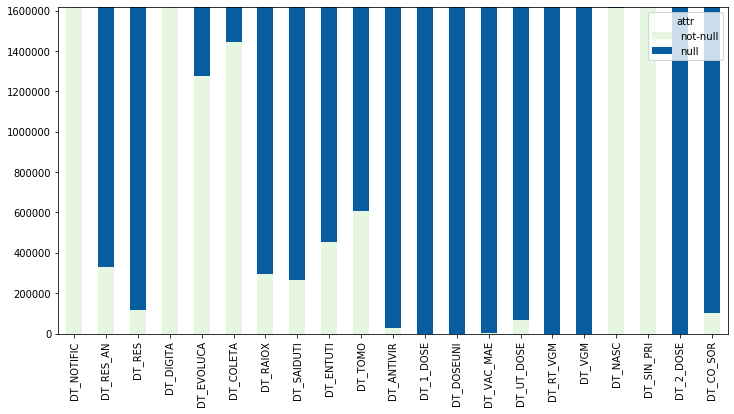

In [15]:
# quantifying nulls
pd_nulls_date_type_cols = srag_2021.select(date_type_columns)

# tagging nulls and not nulls values
for col in date_type_columns:
    pd_nulls_date_type_cols = pd_nulls_date_type_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_dates = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in date_type_columns:
    to_be_joined = pd_nulls_date_type_cols.select(col).groupby(col).count()
    null_dates = null_dates.join(to_be_joined, null_dates['attr'] == to_be_joined[col], 'left')
    null_dates = null_dates.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_dates = null_dates.withColumnRenamed('count', col)

null_dates = null_dates.toPandas()

# Plotting

null_dates.set_index('attr')\
  .reindex(null_dates.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

In [19]:
# !pip install -U seaborn

In [21]:
age_col = srag_2021.select(['AGE_AT_NOTIF', 'NU_IDADE_N']).toPandas()
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=age_col, x="AGE_AT_NOTIF", kde=True, palette="GnBu")

AttributeError: module 'seaborn' has no attribute 'histplot'

In [ ]:
sns.histplot(data=age_col, x="NU_IDADE_N", kde=True, palette="gray")

In [ ]:
# how much cases for year in 2019 srag 
srag_2021.select(F.year("DT_NOTIFIC")).groupBy('year(DT_NOTIFIC)').count().show()

In [ ]:
# how much cases for day
daily_cases = srag_2021.select('DT_NOTIFIC').groupby('DT_NOTIFIC').count().orderBy('DT_NOTIFIC').toPandas()
sns.lineplot(data=daily_cases, x="DT_NOTIFIC", y="count")

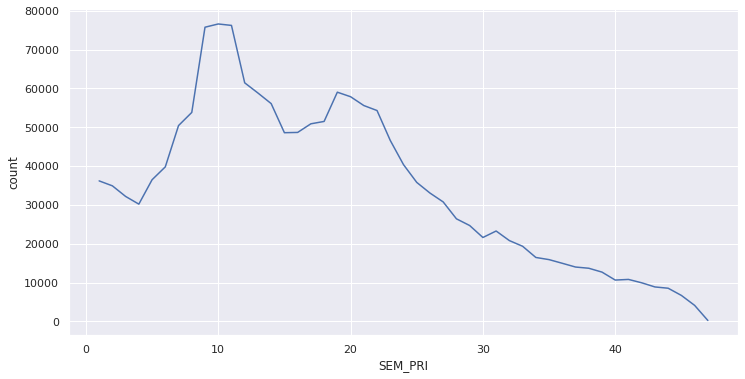

In [22]:
epi_week_cases = srag_2021.select('SEM_PRI').withColumn('SEM_PRI', srag_2021.SEM_PRI.cast(IntegerType()))\
                .groupby('SEM_PRI').count().orderBy('SEM_PRI')\
                .toPandas().dropna()
sns.lineplot(data=epi_week_cases, x="SEM_PRI", y="count")

[Text(0, 0, 'jan'),
 Text(0, 0, 'feb'),
 Text(0, 0, 'apr'),
 Text(0, 0, 'mar'),
 Text(0, 0, 'may')]

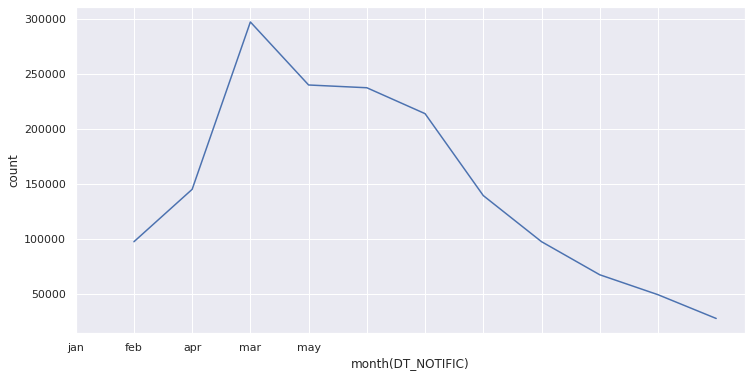

In [23]:
monthly_cases = srag_2021.select('DT_NOTIFIC').groupby(F.month('DT_NOTIFIC')).count().orderBy('month(DT_NOTIFIC)')\
                .toPandas().dropna()
g = sns.lineplot(data=monthly_cases, x="month(DT_NOTIFIC)", y="count")
g.set_xticks(range(len(monthly_cases)))
g.set_xticklabels(['jan','feb','apr','mar','may'])

## formating location variables

### some descriptions

In [24]:
srag_2021.select(location_cat_cols).limit(10).toPandas()

,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,ID_REGIONA,CO_REGIONA,SG_UF,ID_MN_RESI,CO_MUN_RES,CS_ZONA,ID_PAIS,CO_PAIS,HISTO_VGM,PAIS_VGM,CO_PS_VGM,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE
0,SE,ARACAJU,280030,REGIONAL ARACAJU,2056,SE,BARRA DOS COQUEIROS,280060,NaN,BRASIL,1,0,None,None,SE,REGIONAL ARACAJU,2056,ARACAJU,280030
1,MG,SALINAS,315700,MONTES CLAROS,1473,MG,SALINAS,315700,1.0,BRASIL,1,0,None,None,MG,MONTES CLAROS,1473,SALINAS,315700
2,PR,CURITIBA,410690,02RS METROPOLITANA,1356,PR,CURITIBA,410690,1.0,BRASIL,1,0,None,None,PR,02RS METROPOLITANA,1356,CURITIBA,410690
3,SP,SAO JOSE DO RIO PRETO,354980,GVE XXIX SAO JOSE DO RIO PRETO,1354,SP,SAO JOSE DO RIO PRETO,354980,1.0,BRASIL,1,0,None,None,SP,GVE XXIX SAO JOSE DO RIO PRETO,1354,SAO JOSE DO RIO PRETO,354980
4,SP,MAIRIPORA,352850,GVE IX FRANCO DA ROCHA,1334,SP,MAIRIPORA,352850,NaN,BRASIL,1,0,None,None,SP,GVE IX FRANCO DA ROCHA,1334,MAIRIPORA,352850
5,PR,PONTA GROSSA,411990,03RS PONTA GROSSA,1357,PR,PONTA GROSSA,411990,1.0,BRASIL,1,2,None,None,PR,03RS PONTA GROSSA,1357,PONTA GROSSA,411990
6,MG,BELO HORIZONTE,310620,BELO HORIZONTE,1449,MG,CONTAGEM,311860,9.0,BRASIL,1,0,None,None,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620
7,BA,GUANAMBI,291170,NUCLEO REGIONAL DE SAUDE SUDOESTE,1398,BA,CARINHANHA,290710,2.0,BRASIL,1,0,None,None,BA,NUCLEO REGIONAL DE SAUDE SUDOESTE,1398,GUANAMBI,291170
8,SE,ARACAJU,280030,REGIONAL ARACAJU,2056,SE,ARACAJU,280030,1.0,BRASIL,1,2,None,None,SE,REGIONAL ARACAJU,2056,ARACAJU,280030
9,SP,CAMPINAS,350950,GVE XVII CAMPINAS,1342,SP,CAMPINAS,350950,1.0,BRASIL,1,0,None,None,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950


In [25]:
# how much notification occurred in a municipallity far from patient's residence
srag_2021.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .groupBy('DIFF_MUN').count().show()

+--------------+-------+
|      DIFF_MUN|  count|
+--------------+-------+
|DIFFERENT CITY| 477461|
|     SAME CITY|1138348|
+--------------+-------+



In [26]:
# which state exported more notifications to other cities (in or out the same state)
srag_2021.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .filter(F.col('DIFF_MUN') == 'DIFFERENT CITY').groupBy('SG_UF').count().show()

+-----+------+
|SG_UF| count|
+-----+------+
|   SC| 25115|
|   RO|  3505|
|   PI|  5163|
|   AM|  2786|
|   RR|   638|
|   GO| 21225|
| null|   237|
|   TO|  5331|
|   MT|  5381|
|   SP|107158|
|   PB| 11566|
|   ES|  5756|
|   RS| 23928|
|   MS|  4975|
|   AL|  7644|
|   MG| 51726|
|   PA|  7641|
|   BA| 21831|
|   SE|  6735|
|   PE| 23159|
+-----+------+
only showing top 20 rows



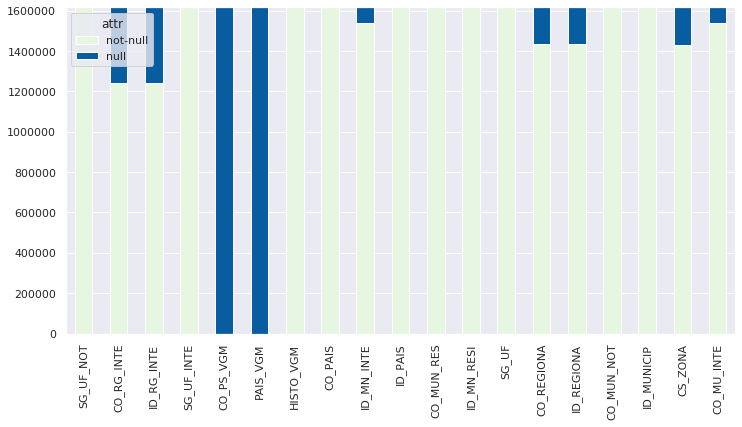

In [27]:
# quantifying nulls
pd_nulls_location_cat_cols = srag_2021.select(location_cat_cols)

# tagging nulls and not nulls values
for col in location_cat_cols:
    pd_nulls_location_cat_cols = pd_nulls_location_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_loc = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in location_cat_cols:
    to_be_joined = pd_nulls_location_cat_cols.select(col).groupby(col).count()
    null_loc = null_loc.join(to_be_joined, null_loc['attr'] == to_be_joined[col], 'left')
    null_loc = null_loc.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_loc = null_loc.withColumnRenamed('count', col)

null_loc = null_loc.toPandas()

# Plotting

null_loc.set_index('attr')\
  .reindex(null_loc.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formating id vars

### some descriptions

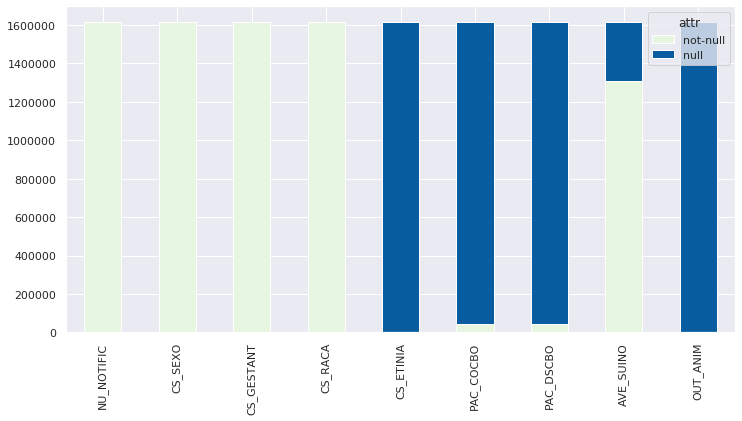

In [28]:
# quantifying nulls
pd_nulls_semi_id_cat_cols = srag_2021.select(semi_id_cat_cols)

# tagging nulls and not nulls values
for col in semi_id_cat_cols:
    pd_nulls_semi_id_cat_cols = pd_nulls_semi_id_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_id = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in semi_id_cat_cols:
    to_be_joined = pd_nulls_semi_id_cat_cols.select(col).groupby(col).count()
    null_id = null_id.join(to_be_joined, null_id['attr'] == to_be_joined[col], 'left')
    null_id = null_id.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_id = null_id.withColumnRenamed('count', col)

null_id = null_id.toPandas()

# Plotting

null_id.set_index('attr')\
  .reindex(null_id.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formatting symptoms variables 

In [29]:
srag_2021.select(symptoms_cat_cols).limit(10).toPandas()

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,FADIGA,PERD_OLFT,PERD_PALA,DOR_ABD
0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
3,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,1.0,1.0,1.0
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
6,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,1.0,NaN,NaN,1.0,NaN,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
8,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
9,1.0,2.0,2.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0


### some descriptions

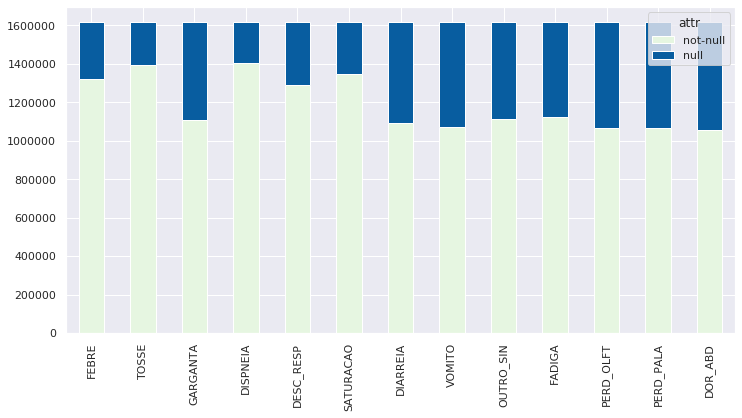

In [30]:
# quantifying nulls
pd_nulls_symptoms_cat_cols = srag_2021.select(symptoms_cat_cols)

# tagging nulls and not nulls values
for col in symptoms_cat_cols:
    pd_nulls_symptoms_cat_cols = pd_nulls_symptoms_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_symp = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in symptoms_cat_cols:
    to_be_joined = pd_nulls_symptoms_cat_cols.select(col).groupby(col).count()
    null_symp = null_symp.join(to_be_joined, null_symp['attr'] == to_be_joined[col], 'left')
    null_symp = null_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_symp = null_symp.withColumnRenamed('count', col)

null_symp = null_symp.toPandas()

# Plotting

null_symp.set_index('attr')\
  .reindex(null_symp.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

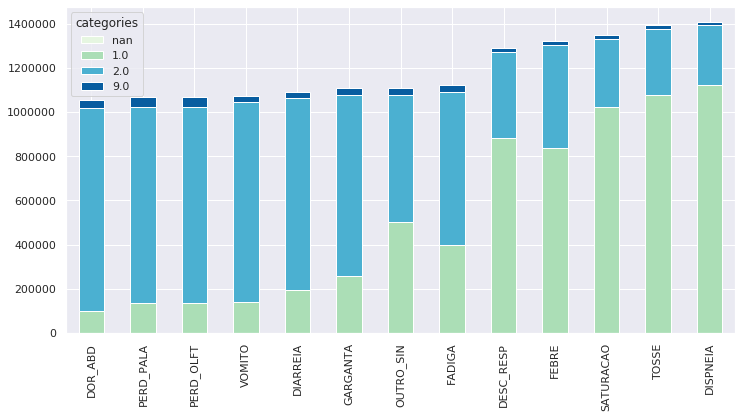

In [31]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
pd_symptoms_cat_cols = srag_2021.select(symptoms_cat_cols)
categories_symp = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in symptoms_cat_cols: 
    to_be_joined = pd_symptoms_cat_cols.select(col).groupby(col).count()
    categories_symp = categories_symp.join(to_be_joined, categories_symp['categories'] == to_be_joined[col], 'left')
    categories_symp = categories_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_symp = categories_symp.withColumnRenamed('count', col)

categories_symp = categories_symp.toPandas()

# Plotting

categories_symp.set_index('categories')\
  .reindex(categories_symp.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  502787


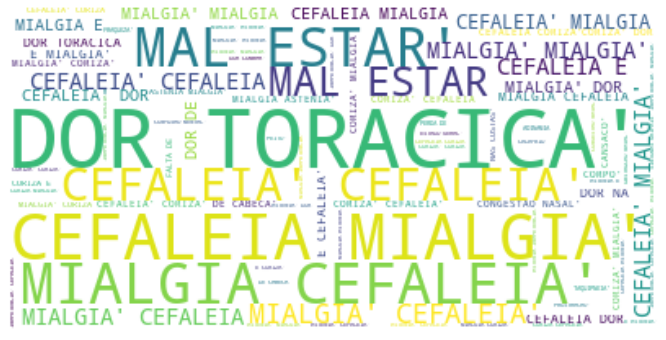

In [32]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_symp_to_wc = srag_2021.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').toPandas()
print('How many cases were filled: ', srag_2021.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').count())

#Final word cloud after all the cleaning and pre-processing
text = another_symp_to_wc['OUTRO_DES'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting risk factor variables 

In [33]:
srag_2021.select(risk_factor_cat_cols).limit(10).toPandas()

,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,FATOR_RISC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2
2,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2,1
3,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2
5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1
6,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2,1
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2
9,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1,1


### some descriptions

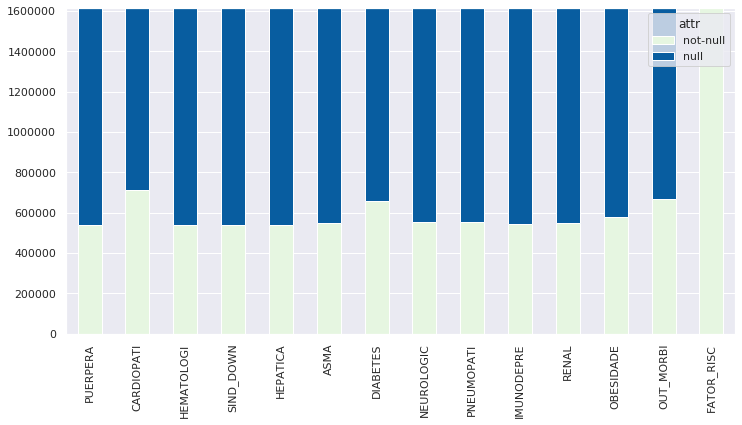

In [34]:
# quantifying nulls
pd_nulls_risk_factor_cat_cols = srag_2021.select(risk_factor_cat_cols)

# tagging nulls and not nulls values
for col in risk_factor_cat_cols:
    pd_nulls_risk_factor_cat_cols = pd_nulls_risk_factor_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_risk = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in risk_factor_cat_cols:
    to_be_joined = pd_nulls_risk_factor_cat_cols.select(col).groupby(col).count()
    null_risk = null_risk.join(to_be_joined, null_risk['attr'] == to_be_joined[col], 'left')
    null_risk = null_risk.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_risk = null_risk.withColumnRenamed('count', col)

null_risk = null_risk.toPandas()

# Plotting

null_risk.set_index('attr')\
  .reindex(null_risk.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

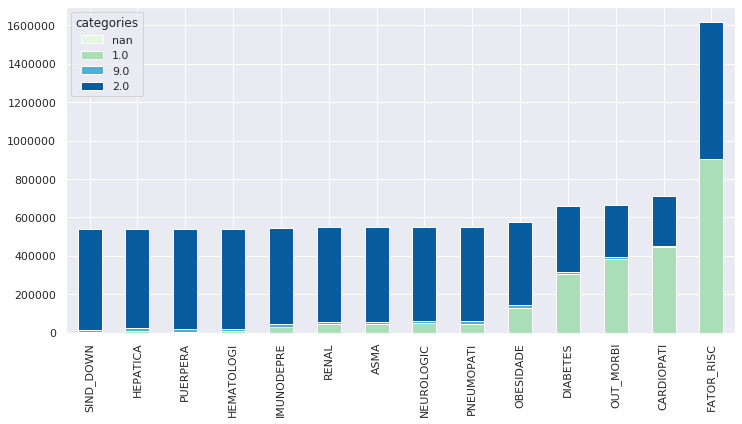

In [35]:
# how distributed are the risk factors
pd_risk_factor = srag_2021.select(risk_factor_cat_cols)
categories_risk_factor = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in risk_factor_cat_cols: 
    to_be_joined = pd_risk_factor.select(col).groupby(col).count()
    categories_risk_factor = categories_risk_factor.join(to_be_joined, categories_risk_factor['categories'] == to_be_joined[col], 'left')
    categories_risk_factor = categories_risk_factor.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_risk_factor = categories_risk_factor.withColumnRenamed('count', col)

categories_risk_factor = categories_risk_factor.toPandas()

# Plotting

categories_risk_factor.set_index('categories')\
  .reindex(categories_risk_factor.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  385283


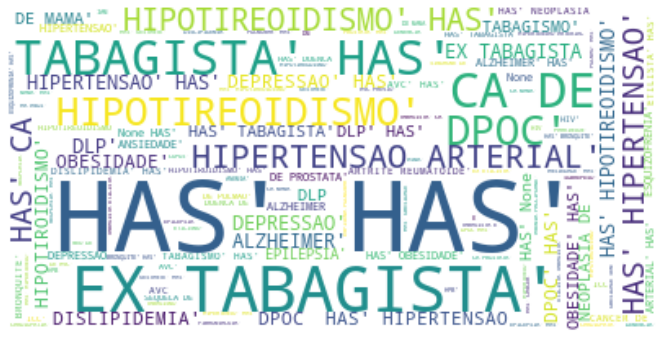

In [36]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_risk_factor_to_wc = srag_2021.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').toPandas()
print('How many cases were filled: ', srag_2021.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').count())

#Final word cloud after all the cleaning and pre-processing

text = another_risk_factor_to_wc['MORB_DESC'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting case description variables 

In [37]:
srag_2021.select(case_desc_cat_cols).limit(10).toPandas()

,SURTO_SG,NOSOCOMIAL,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,TP_SOR,CLASSI_FIN,CRITERIO,EVOLUCAO
0,NaN,NaN,NaN,None,None,NaN,None,1,NaN,NaN,NaN,5,1,3.0
1,2.0,2.0,2.0,None,None,2.0,None,1,1.0,1.0,1.0,5,1,1.0
2,NaN,2.0,9.0,None,None,2.0,None,1,1.0,2.0,NaN,5,1,1.0
3,NaN,NaN,2.0,None,None,2.0,None,1,2.0,2.0,NaN,5,1,1.0
4,NaN,NaN,NaN,None,None,NaN,None,1,NaN,NaN,NaN,5,1,1.0
5,2.0,2.0,2.0,None,None,2.0,None,1,2.0,2.0,NaN,2,1,1.0
6,NaN,NaN,9.0,None,None,9.0,None,1,2.0,2.0,NaN,4,1,1.0
7,NaN,9.0,2.0,None,None,2.0,None,1,2.0,2.0,NaN,4,3,NaN
8,1.0,2.0,NaN,None,None,2.0,None,1,2.0,3.0,NaN,5,1,9.0
9,NaN,2.0,9.0,None,None,2.0,None,1,2.0,2.0,NaN,4,1,1.0


### some descriptions

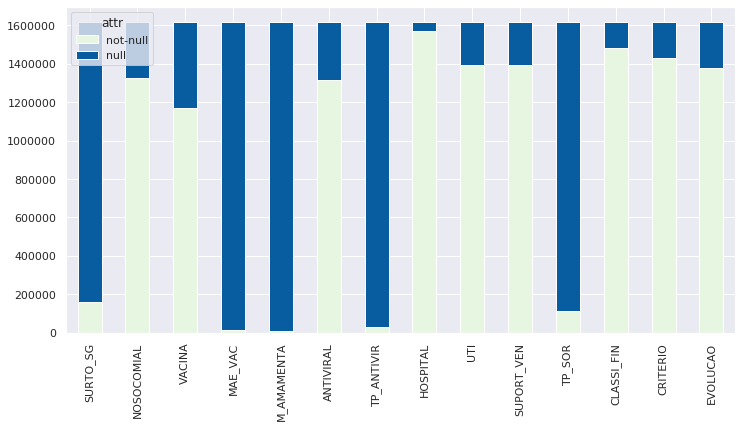

In [38]:
# quantifying nulls
pd_nulls_case_desc_cat_cols = srag_2021.select(case_desc_cat_cols)

# tagging nulls and not nulls values
for col in case_desc_cat_cols:
    pd_nulls_case_desc_cat_cols = pd_nulls_case_desc_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_cases = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in case_desc_cat_cols:
    to_be_joined = pd_nulls_case_desc_cat_cols.select(col).groupby(col).count()
    null_cases = null_cases.join(to_be_joined, null_cases['attr'] == to_be_joined[col], 'left')
    null_cases = null_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_cases = null_cases.withColumnRenamed('count', col)

null_cases = null_cases.toPandas()

# Plotting

null_cases.set_index('attr')\
  .reindex(null_cases.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

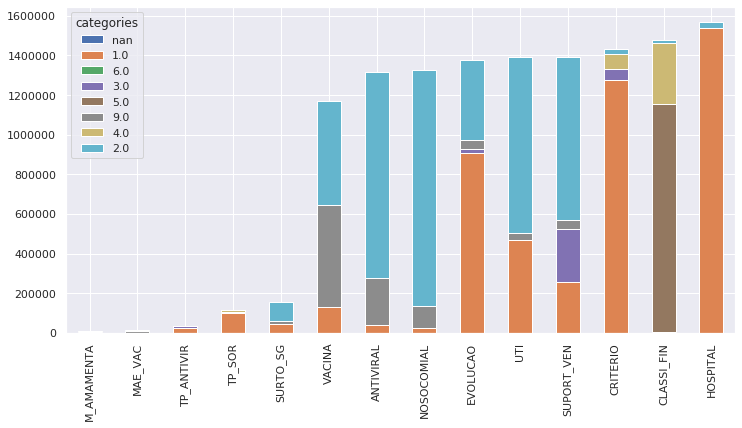

In [39]:
# how distributed are the risk factors
pd_cases = srag_2021.select(case_desc_cat_cols)
categories_cases = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in case_desc_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_cases = categories_cases.join(to_be_joined, categories_cases['categories'] == to_be_joined[col], 'left')
    categories_cases = categories_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_cases = categories_cases.withColumnRenamed('count', col)

categories_cases = categories_cases.toPandas()

# Plotting

categories_cases.set_index('categories')\
  .reindex(categories_cases.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


## formatting tests variables 

In [40]:
srag_2021.select(tests_cat_cols).limit(10).toPandas()

,RES_IGG,RES_IGM,RES_IGA,RAIOX_RES,TOMO_RES,AMOSTRA,TP_AMOSTRA,OUT_SOR,SOR_OUT,TP_AM_SOR,AN_ADENO,POS_AN_FLU,POS_AN_OUT,AN_PARA2,AN_PARA3,TP_FLU_AN,AN_VSR,AN_SARS2,AN_OUTRO,RES_AN,TP_FLU_PCR,PCR_SARS2,PCR_RESUL,POS_PCRFLU,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT
0,None,NaN,None,NaN,NaN,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,4.0,None,1.0,1.0,2.0,None,None,1.0
1,None,1.0,None,6.0,NaN,1.0,4.0,None,None,None,None,None,None,None,None,None,None,None,None,5.0,None,NaN,5.0,NaN,None,None,NaN
2,None,NaN,None,6.0,NaN,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,4.0,None,1.0,1.0,2.0,None,None,1.0
3,None,NaN,None,NaN,NaN,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,4.0,None,1.0,1.0,2.0,None,None,1.0
4,None,NaN,None,NaN,NaN,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,1.0,1.0,NaN,None,None,1.0
5,None,NaN,None,6.0,5.0,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,4.0,None,NaN,1.0,2.0,None,None,1.0
6,None,NaN,None,9.0,5.0,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,4.0,None,NaN,2.0,NaN,None,None,NaN
7,None,NaN,None,9.0,6.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,NaN,NaN,None,None,NaN
8,None,NaN,None,1.0,6.0,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,5.0,None,1.0,1.0,NaN,None,None,1.0
9,None,NaN,None,2.0,NaN,1.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,5.0,None,NaN,2.0,NaN,None,None,NaN


### some descriptions

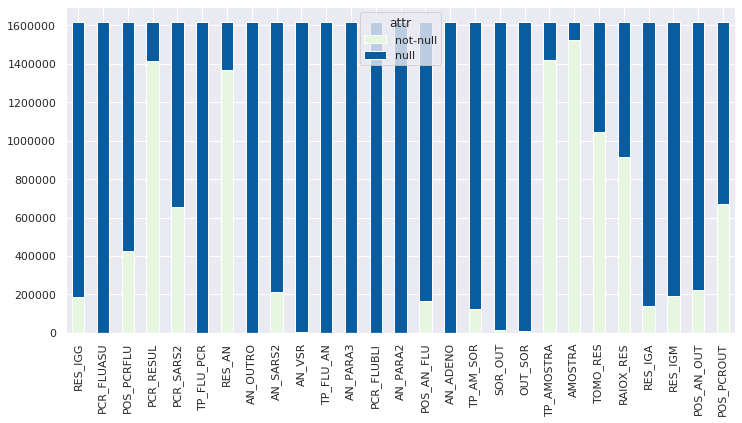

In [41]:
# quantifying nulls
pd_nulls_tests_cat_cols = srag_2021.select(tests_cat_cols)

# tagging nulls and not nulls values
for col in tests_cat_cols:
    pd_nulls_tests_cat_cols = pd_nulls_tests_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_tests = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in tests_cat_cols:
    to_be_joined = pd_nulls_tests_cat_cols.select(col).groupby(col).count()
    null_tests = null_tests.join(to_be_joined, null_tests['attr'] == to_be_joined[col], 'left')
    null_tests = null_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_tests = null_tests.withColumnRenamed('count', col)

null_tests = null_tests.toPandas()

# Plotting

null_tests.set_index('attr')\
  .reindex(null_tests.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

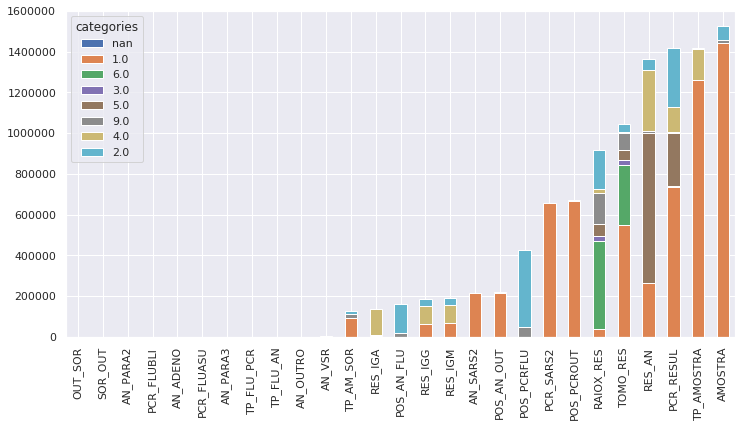

In [42]:
# how distributed are the tests
pd_cases = srag_2021.select(tests_cat_cols)
categories_tests = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in tests_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_tests = categories_tests.join(to_be_joined, categories_tests['categories'] == to_be_joined[col], 'left')
    categories_tests = categories_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_tests = categories_tests.withColumnRenamed('count', col)

categories_tests = categories_tests.toPandas()

# Plotting

categories_tests.set_index('categories')\
  .reindex(categories_tests.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


<hr />

# Creating first part of Super SRAG dataset

<hr />

## variables of interest

In [43]:
# from 2019
id_cols_2019 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2019 = ['SEM_PRI', 'SEM_NOT', 'DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2019 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2019 = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2019 = ['RAIOX_RES', 'DT_RAIOX', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'IF_RESUL', 'DT_IF', 'POS_IF_FLU', 'TP_FLU_IF', 'POS_IF_OUT', 'IF_VSR', 'IF_PARA1', 'IF_PARA2', 'IF_PARA3', 'IF_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO']

In [44]:
# from 2020
id_cols_2020 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2020 = ['SEM_PRI', 'SEM_NOT','DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2020 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA',
                   'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2020 = ['FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2020 = ['RAIOX_RES', 'DT_RAIOX', 'TOMO_RES', 'DT_TOMO', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'TP_TES_AN', 'DT_RES_AN', 'RES_AN', 'POS_AN_FLU', 'TP_FLU_AN', 'POS_AN_OUT', 'AN_SARS2', 'AN_VSR', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO',
                  'TP_AM_SOR', 'DT_CO_SOR', 'TP_SOR', 'RES_SOR', 'RES_IGG', 'RES_IGM', 'RES_IGA', 'DT_RES']

In [45]:
# from 2021
id_cols_2021 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2021 = ['SEM_PRI', 'SEM_NOT', 'DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2021 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA',
                   'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2021 = ['FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2021 = ['RAIOX_RES', 'DT_RAIOX', 'TOMO_RES', 'DT_TOMO', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'TP_TES_AN', 'DT_RES_AN', 'RES_AN', 'POS_AN_FLU', 'TP_FLU_AN', 'POS_AN_OUT', 'AN_SARS2', 'AN_VSR', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO',
                  'TP_AM_SOR', 'DT_CO_SOR', 'TP_SOR', 'RES_SOR', 'RES_IGG', 'RES_IGM', 'RES_IGA', 'DT_RES']

<hr />

# writing intermediate results

<hr />

In [46]:
srag_2021.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021-UPDATE-28-11-2021', mode='overwrite')

<hr />

## About tests

<hr />

In [133]:
srag_2021 = spark.read.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021-UPDATE-28-11-2021').repartition(256)

In [134]:
# is the NU_NOTIFIC reliable to be primary key? 
print('how much records do we have? ',srag_2021.count())
print('how manny NU_NOTIFIC are unique? ', srag_2021.select('NU_NOTIFIC').distinct().count())

how much records do we have?  1615809
how manny NU_NOTIFIC are unique?  1615809


## Creating PP_IF_RESUL

### srag_2021

In [135]:
# how was 'TP_TES_AN' col before? 
print("how many records with IF test in srag 2021? ", srag_2021.filter(F.col('TP_TES_AN') == '1').count())
print("how many of those are positive? ", srag_2021.filter((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & (F.col('AN_SARS2').isNotNull()))).count())
srag_2021.filter(F.col('TP_TES_AN') == '1').select('RES_AN').groupBy('RES_AN').count().orderBy('RES_AN').show()

how many records with IF test in srag 2021?  34281
how many of those are positive?  15516
+------+-----+
|RES_AN|count|
+------+-----+
|  null|  562|
|     1|22729|
|     2| 5627|
|     3|   22|
|     4| 3573|
|     5| 1655|
|     9|  113|
+------+-----+



In [136]:
srag_2021 = srag_2021.withColumn('PP_IF_RESUL', F.when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '3'), '5')\
                                                 .when(((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') != '9') | (F.col('RES_AN').isNotNull()))), '6')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [137]:
# how was 'PP_IF_RESUL' col after? 
srag_2021.select('PP_IF_RESUL').groupBy('PP_IF_RESUL').count().orderBy('PP_IF_RESUL').show()

+-----------+-------+
|PP_IF_RESUL|  count|
+-----------+-------+
|          1|    118|
|          2|  15496|
|          3|   1509|
|          4|   5627|
|          5|     22|
|          6| 284787|
|          7|   1649|
|          9|1306601|
+-----------+-------+



## Creating PP_TRA_RESUL

### srag_2021

In [138]:
srag_2021.filter(F.col('TP_TES_AN') == '2').groupBy('RES_AN').count().orderBy('RES_AN').show()

+------+------+
|RES_AN| count|
+------+------+
|  null|  3747|
|     1|233268|
|     2| 44611|
|     3|    96|
|     4|  2652|
|     5|  3976|
|     9|   184|
+------+------+



In [139]:
srag_2021 = srag_2021.withColumn('PP_TRA_RESUL', F.when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '3'), '5')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '4') | (F.col('RES_AN').isNull())), '6')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [140]:
srag_2021.select('PP_TRA_RESUL').groupBy('PP_TRA_RESUL').count().orderBy('PP_TRA_RESUL').show()

+------------+-------+
|PP_TRA_RESUL|  count|
+------------+-------+
|           1|    234|
|           2| 192278|
|           3|   1883|
|           4|  44611|
|           5|     96|
|           6|   5968|
|           7|   3858|
|           9|1366881|
+------------+-------+



## Creating PP_PCR_RESUL

### srag_2021

In [141]:
# how was 'PCR_RESUL' col before? 
srag_2021.select('PCR_RESUL').groupBy('PCR_RESUL').count().orderBy('PCR_RESUL').show()

+---------+------+
|PCR_RESUL| count|
+---------+------+
|     null|199008|
|        1|738097|
|        2|290236|
|        3|  3277|
|        4|122845|
|        5|257290|
|        9|  5056|
+---------+------+



In [142]:
srag_2021 = srag_2021.withColumn('PP_PCR_RESUL', F.when((F.col('PCR_RESUL') == '1') & 
                                                        (((F.col('POS_PCRFLU') == '1') | (F.col('TP_FLU_PCR').isNotNull())) |
                                                         ((F.col('PCR_FLUASU').isNotNull()) | (F.col('PCR_FLUASU') == '1') | (F.col('PCR_FLUASU') == '2') | (F.col('PCR_FLUASU') == '3') | (F.col('PCR_FLUASU') == '4') | (F.col('PCR_FLUASU') == '6') | (((F.col('PCR_FLUBLI').isNotNull()) & (F.col('PCR_FLUBLI') != '4'))))), '1')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & (F.col('PCR_SARS2').isNotNull()), '2')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & 
                                                        ((F.col('POS_PCROUT') == '1') | (F.col('PCR_VSR').isNotNull() | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA2').isNotNull()) | (F.col('PCR_PARA3').isNotNull()) | (F.col('PCR_PARA4').isNotNull()) | (F.col('PCR_ADENO').isNotNull()) | (F.col('PCR_METAP').isNotNull())| (F.col('PCR_BOCA').isNotNull())| (F.col('PCR_RINO').isNotNull())| (F.col('PCR_OUTRO').isNotNull()))), '3')\
                                                  .when(F.col('PCR_RESUL') == '2', '4')\
                                                  .when(F.col('PCR_RESUL') == '3', '5')\
                                                  .when((F.col('PCR_RESUL') == '4') | (F.col('PCR_RESUL').isNull()), '6')\
                                                  .when(F.col('PCR_RESUL') == '5', '7')\
                                                  .otherwise(F.lit('9')))            

In [143]:
# how was 'PP_PCR_RESUL' col before? 
srag_2021.select('PP_PCR_RESUL').groupBy('PP_PCR_RESUL').count().orderBy('PP_PCR_RESUL').show()

+------------+------+
|PP_PCR_RESUL| count|
+------------+------+
|           1|   153|
|           2|654672|
|           3| 13097|
|           4|290236|
|           5|  3277|
|           6|321853|
|           7|257290|
|           9| 75231|
+------------+------+



## Creating PP_RES_SOR_{IGA, IGM, IGG}

### srag 2021

In [144]:
for exam in ['IGA', 'IGM', 'IGG']:
    print('how was RES_' + exam + ' col before?')
    srag_2021.select('RES_'+exam).groupBy('RES_'+exam).count().orderBy('RES_'+exam).show()
    srag_2021 = srag_2021.withColumnRenamed('RES_'+exam, 'PP_RES_SOR_'+exam).withColumn('PP_RES_SOR_'+exam, 
                                                                                F.when(F.col('PP_RES_SOR_'+exam).isNull(), '4').otherwise(F.col('PP_RES_SOR_'+exam)))
    print('how was PP_RES_SOR_' + exam + ' col after?') 
    srag_2021.select('PP_RES_SOR_'+exam).groupBy('PP_RES_SOR_'+exam).count().orderBy('PP_RES_SOR_'+exam).show()

how was RES_IGA col before?
+-------+-------+
|RES_IGA|  count|
+-------+-------+
|   null|1477471|
|      1|   4943|
|      2|   3469|
|      3|    331|
|      4| 123464|
|      5|    374|
|      9|   5757|
+-------+-------+

how was PP_RES_SOR_IGA col after?
+--------------+-------+
|PP_RES_SOR_IGA|  count|
+--------------+-------+
|             1|   4943|
|             2|   3469|
|             3|    331|
|             4|1600935|
|             5|    374|
|             9|   5757|
+--------------+-------+

how was RES_IGM col before?
+-------+-------+
|RES_IGM|  count|
+-------+-------+
|   null|1424647|
|      1|  66343|
|      2|  36264|
|      3|    225|
|      4|  85453|
|      5|    329|
|      9|   2548|
+-------+-------+

how was PP_RES_SOR_IGM col after?
+--------------+-------+
|PP_RES_SOR_IGM|  count|
+--------------+-------+
|             1|  66343|
|             2|  36264|
|             3|    225|
|             4|1510100|
|             5|    329|
|             9|   2548|
+-

<hr />

## Creating DIST_DT vars

<hr />

In [145]:
print('how many DT_SIN_PRI are Null: ', srag_2021.filter(F.col('DT_SIN_PRI').isNull()).count())

how many DT_SIN_PRI are Null:  0


In [146]:
# to do: inclue DT_INTERNA at the preprocessing on date type columns
srag_2021 = srag_2021.withColumn('DT_INTERNA', F.to_date(F.col('DT_INTERNA'), 'dd/MM/yyyy'))

# to do: inclue DT_ENCERRA at the preprocessing on date type columns
srag_2021 = srag_2021.withColumn('DT_ENCERRA', F.to_date(F.col('DT_ENCERRA'), 'dd/MM/yyyy'))

# to do: inclue DT_PCR at the preprocessing on date type columns
srag_2021 = srag_2021.withColumn('DT_PCR', F.to_date(F.col('DT_PCR'), 'dd/MM/yyyy'))

In [147]:
# Creating date variables exclusive for antigenic and rapid tests on both srag years
srag_2021 = srag_2021.withColumn('DT_IF', F.when(F.col('TP_TES_AN') == '1', F.col('DT_RES_AN')).otherwise(None))

srag_2021 = srag_2021.withColumn('DT_TRA', F.when(F.col('TP_TES_AN') == '2', F.col('DT_RES_AN')).otherwise(None))

In [148]:
# setting cols' names - part 1
event_col = 'DT_SIN_PRI'
dt_cols_convert = {
    'DIST_PRI_NOTIFIC':['DT_NOTIFIC', [3.0, 5.0, 8.0, 12.0]],
    'DIST_PRI_INTERNA':['DT_INTERNA', [2.0, 4.0, 7.0, 10.0]],
    'DIST_PRI_ENTUTI':['DT_ENTUTI', [2.0, 5.0, 8.0, 11.0]],
    'DIST_PRI_SAIDUTI':['DT_SAIDUTI', [8.0, 13.0, 18.0, 27.0]],
    'DIST_PRI_EVOLUCA':['DT_EVOLUCA', [7.0, 12.0, 16.0, 23.0]],
    'DIST_PRI_ENCERRA':['DT_ENCERRA', [12.0, 18.0, 27.0, 45.0]],
    'DIST_PRI_RAIOX':['DT_RAIOX', [2.0, 4.0, 6.0, 10.0]],
    'DIST_PRI_TOMO':['DT_TOMO', [3.0, 6.0, 8.0, 11.0]],
    'DIST_PRI_COLETA':['DT_COLETA', [2.0, 3.0, 5.0, 9.0]],
    'DIST_PRI_SOR':['DT_CO_SOR', [3.0, 6.0, 9.0, 12.0]],
    'DIST_PRI_PCR':['DT_PCR', [4.0, 6.0, 9.0, 12.0]],
    'DIST_PRI_TRA':['DT_TRA', [2.0, 3.0, 5.0, 8.0]],
    'DIST_PRI_IF':['DT_IF', [3.0, 6.0, 9.0, 14.0]]
}

In [149]:
all_srags = srag_2021

In [150]:
for col in list(dt_cols_convert.keys()):
    all_srags = all_srags.withColumn(col, F.datediff(F.col(dt_cols_convert[col][0]), F.col(event_col)))

In [151]:
for col in list(dt_cols_convert.keys()):
    all_srags = all_srags.withColumn(col+'_q', F.when(F.col(col) <= dt_cols_convert[col][1][0], '1')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][0]) &  (F.col(col) <= dt_cols_convert[col][1][1]), '2')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][1]) &  (F.col(col) <= dt_cols_convert[col][1][2]), '3')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][2]) &  (F.col(col) <= dt_cols_convert[col][1][3]), '4')\
                                                                  .when(F.col(col) > dt_cols_convert[col][1][3], '5')\
                                                                  .otherwise('6'))

In [152]:
all_srags.limit(10).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,...,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,PP_RES_SOR_IGG,PP_RES_SOR_IGM,PP_RES_SOR_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV,NU_NOTIFIC,AGE_AT_NOTIF,PP_IF_RESUL,PP_TRA_RESUL,PP_PCR_RESUL,DT_IF,DT_TRA,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,2021-06-05,22,2021-06-01,22,SP,GVE X OSASCO,1335.0,BARUERI,350570,PS E MATERNIDADE NAIR FONSECA LEITAO ARANTES,2082209,M,1970-01-05,51,3,3051,6,1,None,NaN,BRASIL,1,SP,GVE X OSASCO,1335.0,BARUERI,350570,1.0,None,2,9.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,None,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,None,None,4,4,4,2.0,2,None,None,None,None,None,1.0,249108772131,51,9,9,2,None,None,4,4.0,NaN,NaN,12.0,13.0,NaN,NaN,4.0,None,6.0,NaN,None,2,2,6,6,2,2,6,6,3,6,2,6,6
1,2021-03-30,13,2021-03-20,11,CE,11 CRES SOBRAL,1521.0,SOBRAL,231290,HOSPITAL DR FRANCISCO ALVES,100358,M,1991-08-14,29,3,3029,6,4,None,NaN,BRASIL,1,CE,11 CRES SOBRAL,1521.0,ALCANTARAS,230050,NaN,None,2,2.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,ASTENIA E TONTURA,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,None,None,4,4,4,2.0,9,None,None,None,None,None,1.0,249108826904,29,9,9,7,None,None,10,10.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,None,NaN,NaN,None,4,4,6,6,6,6,6,6,4,6,6,6,6
2,2021-03-12,10,2021-03-07,10,RS,001 CRS,1592.0,SALVADOR DO SUL,431650,HOSPITAL SAO SALVADOR,2227681,F,1937-10-15,83,3,3083,6,1,None,1.0,BRASIL,1,RS,001 CRS,1592.0,SALVADOR DO SUL,431650,1.0,None,2,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,None,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,None,None,4,4,4,NaN,1,26/02/2021,30/03/2021,FUNDACAO BUTANTAN,200279,210107,1.0,249108811426,83,9,9,2,None,None,5,3.0,NaN,NaN,8.0,9.0,3.0,4.0,3.0,None,5.0,NaN,None,2,2,6,6,2,1,2,2,2,6,2,6,6
3,2021-06-09,23,2021-05-21,20,SP,GVE X OSASCO,1335.0,OSASCO,353440,HOSPITAL REGIONAL DR VIVALDO MARTINS SIMOES OS...,8052,F,1973-10-10,47,3,3047,5,1,None,2.0,BRASIL,1,SP,GVE XXXI SOROCABA,1353.0,PILAR DO SUL,353790,1.0,None,2,9.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,QUEDA FUNCAO RENAL,2.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,None,None,None,NaN,None,None,4,4,4,2.0,2,None,None,None,None,None,1.0,249108778990,47,9,9,2,None,None,19,19.0,19.0,21.0,21.0,21.0,NaN,12.0,0.0,None,25.0,NaN,None,5,5,5,4,4,3,6,5,1,6,5,6,6
4,2021-06-01,22,2021-05-28,21,MG,BELO HORIZONTE,1449.0,BELO HORIZONTE,310620,UNIDADE DE PRONTO ATENDIMENTO NORTE,23272,F,1955-03-13,66,3,3066,6,1,None,1.0,BRASIL,1,MG,BELO HORIZONTE,1449.0,BELO HORIZONTE,310620,1.0,None,2,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,None,2.0,1,1.0,2.0,2.0,2.0,1.0,1.0,2.0,...,None,None,None,NaN,None,None,4,4,4,2.0,1,08/04/2021,None,CORONAVAC,210090,None,1.0,249108724069,66,9,9,4,None,None,4,NaN,NaN,NaN,5.0,18.0,NaN,NaN,4.0,None,7.0,NaN,None,2,6,6,6,1,2,6,6,3,6,3,6,6
5,2021-09-12,37,2021-09-12,37,PR,02RS METROPOLITANA,1356.0,ARAUCARIA,410180,CENTRO ESPECIALIZADO DE COMBATE AO CORONAVIRUS...,107972,F,1925-04-21,96,3,3096,5,1,None,9.0,BRASIL,1,PR,02RS METROPOLITANA,1356.0,ARAUCARIA,410180,1.0,None,9,9.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,None,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,NaN,None,None,4,4,4,2.0,1,11/02/2021,09/03/2021,CO

In [153]:
dt_cols = [x[0] for x in dt_cols_convert.values()]
interest_list = all_srags.columns
for col in dt_cols:
    interest_list.remove(col)
interest_list.remove('DT_SIN_PRI')

In [154]:
interest_list

['SEM_NOT',
 'SEM_PRI',
 'SG_UF_NOT',
 'ID_REGIONA',
 'CO_REGIONA',
 'ID_MUNICIP',
 'CO_MUN_NOT',
 'ID_UNIDADE',
 'CO_UNI_NOT',
 'CS_SEXO',
 'DT_NASC',
 'NU_IDADE_N',
 'TP_IDADE',
 'COD_IDADE',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ETINIA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'CO_PAIS',
 'SG_UF',
 'ID_RG_RESI',
 'CO_RG_RESI',
 'ID_MN_RESI',
 'CO_MUN_RES',
 'CS_ZONA',
 'SURTO_SG',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'FEBRE',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'OUTRO_SIN',
 'OUTRO_DES',
 'PUERPERA',
 'FATOR_RISC',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'OBES_IMC',
 'OUT_MORBI',
 'MORB_DESC',
 'VACINA',
 'DT_UT_DOSE',
 'MAE_VAC',
 'DT_VAC_MAE',
 'M_AMAMENTA',
 'DT_DOSEUNI',
 'DT_1_DOSE',
 'DT_2_DOSE',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'OUT_ANTIV',
 'DT_ANTIVIR',
 'HOSPITAL',
 'SG_UF_INTE',
 'ID_RG_INTE',
 'CO_RG_INTE',
 'ID_MN_INTE',
 'CO_MU_INTE',
 '

In [155]:
srag_2021 = srag_2021.join(all_srags.select(interest_list), 'NU_NOTIFIC', 'left')

In [161]:
def dropDupeDfCols(df):
    newcols = []
    dupcols = []

    for i in range(len(df.columns)):
        if df.columns[i] not in newcols:
            newcols.append(df.columns[i])
        else:
            dupcols.append(i)

    df = df.toDF(*[str(i) for i in range(len(df.columns))])
    for dupcol in dupcols:
        df = df.drop(str(dupcol))

    return df.toDF(*newcols)

In [ ]:
srag_2021 = dropDupeDfCols(srag_2021)

In [156]:
if (srag_2021.count() == srag_2021.select('NU_NOTIFIC').distinct().count()) and (srag_2021.count() == 1615809):
    print('SRAG_2021 OK')

SRAG_2021 OK


In [157]:
srag_2021.select('DIST_PRI_NOTIFIC_q').limit(2).show()

+------------------+
|DIST_PRI_NOTIFIC_q|
+------------------+
|                 5|
|                 2|
+------------------+



In [158]:
# just for check the header later
srag_2021.limit(1).toPandas()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,...,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,TP_SOR,OUT_SOR,DT_RES,PP_RES_SOR_IGG,PP_RES_SOR_IGM,PP_RES_SOR_IGA,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV,AGE_AT_NOTIF,PP_IF_RESUL,PP_TRA_RESUL,PP_PCR_RESUL,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,206159025128,2021-01-13,2,2021-01-10,2,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HOSP MUN DR BENEDICTO MONTENEGRO,2084139,F,1938-05-15,82,3,3082,5,1,None,None,BRASIL,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,1,2,2,2,2,2,2,1,1,1,1,2,2,None,2,1,2,2,2,2,2,1,...,None,None,None,None,None,None,None,None,None,4,4,4,None,None,None,None,None,None,None,None,82,9,9,2,3,3,None,None,5,31,3,None,3,None,6,None,None,1,2,6,6,1,4,2,6,2,6,2,6,6


<hr />

# Creating Group of symptoms

<hr />

## srag_2021

#### SYMP_GROUP1

In [159]:
# group 1
sym_g_v = ['FEBRE', 'TOSSE', 'GARGANTA']

In [160]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

AnalysisException: "Reference 'FEBRE' is ambiguous, could be: FEBRE, FEBRE.;"

In [ ]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP1', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [ ]:
srag_2021.groupBy('SYMP_GROUP1').count().orderBy('SYMP_GROUP1').show()

#### SYMP_GROUP2

In [ ]:
# group 2
sym_g_v = ['DISPNEIA', 'DESC_RESP', 'SATURACAO']

In [ ]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

In [ ]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP2', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [ ]:
srag_2021.groupBy('SYMP_GROUP2').count().orderBy('SYMP_GROUP2').show()

#### SYMP_GROUP3

In [ ]:
# group 3
sym_g_v = ['DIARREIA', 'VOMITO', 'DOR_ABD']

In [ ]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

In [ ]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP3', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [ ]:
srag_2021.groupBy('SYMP_GROUP3').count().orderBy('SYMP_GROUP3').show()

#### SYMP_GROUP4

In [ ]:
# group 4
sym_g_v = ['PERD_PALA', 'PERD_OLFT', 'FADIGA']

In [ ]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

In [ ]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP4', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [ ]:
srag_2021.groupBy('SYMP_GROUP4').count().orderBy('SYMP_GROUP4').show()

# Creating Group of risk factors

## srag_2021

#### RF_GROUP1

In [145]:
# group 1
rf_g_v = ['HEMATOLOGI', 'CARDIOPATI', 'PUERPERA']

In [146]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----------+------+
|HEMATOLOGI| count|
+----------+------+
|      null|569980|
|         1|  4988|
|         2|286429|
|         9|  6970|
+----------+------+

+----------+------+
|CARDIOPATI| count|
+----------+------+
|      null|473803|
|         1|251017|
|         2|139712|
|         9|  3835|
+----------+------+

+--------+------+
|PUERPERA| count|
+--------+------+
|    null|570839|
|       1|  2789|
|       2|287925|
|       9|  6814|
+--------+------+



In [147]:
srag_2021 = srag_2021.withColumn('RF_GROUP1', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [148]:
srag_2021.groupBy('RF_GROUP1').count().orderBy('RF_GROUP1').show()

+---------+------+
|RF_GROUP1| count|
+---------+------+
|        1|472918|
|        2|  1075|
|        3| 97711|
|        4|   493|
|        5|   951|
|        6|     5|
|        8|    23|
|        9|295191|
+---------+------+



#### RF_GROUP2

In [149]:
# group 2
rf_g_v = ['ASMA', 'HEPATICA', 'SIND_DOWN']

In [150]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----+------+
|ASMA| count|
+----+------+
|null|565340|
|   1| 22320|
|   2|274322|
|   9|  6385|
+----+------+

+--------+------+
|HEPATICA| count|
+--------+------+
|    null|570876|
|       1|  5928|
|       2|284626|
|       9|  6937|
+--------+------+

+---------+------+
|SIND_DOWN| count|
+---------+------+
|     null|570910|
|        1|  2572|
|        2|288507|
|        9|  6378|
+---------+------+



In [151]:
srag_2021 = srag_2021.withColumn('RF_GROUP2', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [152]:
srag_2021.groupBy('RF_GROUP2').count().orderBy('RF_GROUP2').show()

+---------+------+
|RF_GROUP2| count|
+---------+------+
|        1|565789|
|        2|  8145|
|        3|  1901|
|        4|    47|
|        5|   679|
|        6|    13|
|        8|   100|
|        9|291693|
+---------+------+



#### RF_GROUP3

In [153]:
# group 3
rf_g_v = ['PNEUMOPATI', 'NEUROLOGIC', 'DIABETES']

In [154]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----------+------+
|PNEUMOPATI| count|
+----------+------+
|      null|563790|
|         1| 24108|
|         2|273726|
|         9|  6743|
+----------+------+

+----------+------+
|NEUROLOGIC| count|
+----------+------+
|      null|563646|
|         1| 26322|
|         2|271839|
|         9|  6560|
+----------+------+

+--------+------+
|DIABETES| count|
+--------+------+
|    null|502198|
|       1|174350|
|       2|187276|
|       9|  4543|
+--------+------+



In [155]:
srag_2021 = srag_2021.withColumn('RF_GROUP3', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [156]:
srag_2021.groupBy('RF_GROUP3').count().orderBy('RF_GROUP3').show()

+---------+------+
|RF_GROUP3| count|
+---------+------+
|        1|492511|
|        2|  6061|
|        3|  6528|
|        4|   371|
|        5| 67788|
|        6|  1957|
|        8|   633|
|        9|292518|
+---------+------+



#### RF_GROUP4

In [157]:
# group 4
rf_g_v = ['OBESIDADE', 'RENAL', 'IMUNODEPRE']

In [158]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+---------+------+
|OBESIDADE| count|
+---------+------+
|     null|549960|
|        1| 68792|
|        2|241841|
|        9|  7774|
+---------+------+

+-----+------+
|RENAL| count|
+-----+------+
| null|565541|
|    1| 23361|
|    2|272895|
|    9|  6570|
+-----+------+

+----------+------+
|IMUNODEPRE| count|
+----------+------+
|      null|567416|
|         1| 16897|
|         2|277178|
|         9|  6876|
+----------+------+



In [159]:
srag_2021 = srag_2021.withColumn('RF_GROUP4', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [160]:
srag_2021.groupBy('RF_GROUP4').count().orderBy('RF_GROUP4').show()

+---------+------+
|RF_GROUP4| count|
+---------+------+
|        1|538380|
|        2| 24687|
|        3|  7378|
|        4|   573|
|        5|  5219|
|        6|   272|
|        8|   212|
|        9|291646|
+---------+------+



<hr />

In [162]:
# writing final version after creating variables

In [165]:
srag_2021.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021_v3_new_attr-UPDATE-28-11-2021', mode='overwrite')

<hr />